## Basic MCMC

In this tutorial we will go through how to infer a transmission string from light curve data using the MCMC package, emcee.

To start, let us simulate the transit light curve data for a known transmission string.

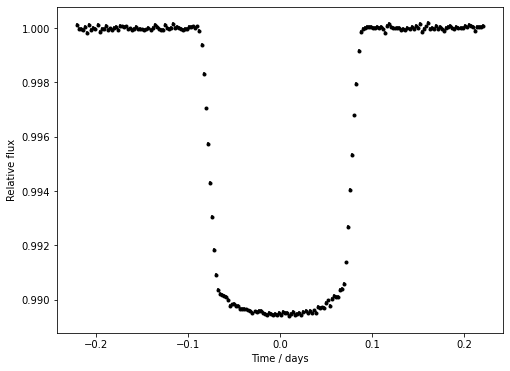

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from harmonica import HarmonicaTransit


np.random.seed(1)
n_obs = 200
times = np.linspace(-0.22, 0.22, n_obs)
us = np.array([0.074, 0.193])
rs = np.array([0.1, -0.003, 0., 0.003, 0.])
var_names = ['a_0', 'a_1', 'b_1', 'a_2', 'b_2']
y_sigma = 70.e-6
y_errs = np.random.normal(loc=0., scale=y_sigma, size=n_obs)

ht = HarmonicaTransit(times, pnl_c=20, pnl_e=50)
ht.set_orbit(t0=0., period=3.735, a=7.025, inc=86.9 * np.pi / 180.)
ht.set_stellar_limb_darkening(us, limb_dark_law='quadratic')
ht.set_planet_transmission_string(rs)
observed_fluxes = ht.get_transit_light_curve() + y_errs

fig = plt.figure(figsize=(8, 6))
ax1 = plt.subplot(1, 1, 1)
ax1.errorbar(times, observed_fluxes, yerr=y_sigma, fmt=".k", capsize=0)
ax1.set_xlabel('Time / days')
ax1.set_ylabel('Relative flux')
plt.show()

Now, let us fit this data using the MCMC package, emcee. We will use the typical likelihhod function used for Gaussian distributed uncertainties, and wide normal priors. 

In [29]:
import emcee
import multiprocessing


def log_prob(params):
    """ Typical Gaussian likelihood. """
    # Ln prior.
    ln_prior = -0.5 * np.sum(((params[0] - 0.1) / 0.01)**2)
    ln_prior += -0.5 * np.sum((params[1:] / 0.005)**2)

    # Ln likelihood.
    ht.set_planet_transmission_string(params)
    model = ht.get_transit_light_curve()
    ln_like = -0.5 * np.sum((observed_fluxes - model)**2 / y_sigma**2
                            + np.log(2 * np.pi * y_sigma**2))

    return ln_like + ln_prior


coords = np.array([0.1, 0., 0., 0., 0.]) + 1.e-5 * np.random.randn(18, len(rs))
sampler = emcee.EnsembleSampler(coords.shape[0], coords.shape[1], log_prob)
state = sampler.run_mcmc(coords, 15000, progress=True)
chain = sampler.get_chain(discard=7500, flat=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15000/15000 [06:51<00:00, 36.43it/s]


First, we check the results and convergence.

In [30]:
import arviz as az


emcee_data = az.from_emcee(sampler, var_names)
az.summary(emcee_data, var_names, round_to=6)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_0,0.099964,0.000047,0.099874,0.100051,0.000001,0.000001,2465.019924,6949.773834,1.005130
a_1,-0.003444,0.000426,-0.004182,-0.002734,0.000008,0.000006,2592.883603,6352.218872,1.006217
b_1,-0.001024,0.000962,-0.002849,0.000774,0.000019,0.000013,2588.049509,6877.142149,1.004539
a_2,0.003364,0.001148,0.001242,0.005559,0.000024,0.000017,2333.118143,6283.291095,1.002409
b_2,0.001370,0.001187,-0.000881,0.003607,0.000023,0.000016,2747.561626,7801.600882,1.003383


Second, we sample the inferred posterior distribution and look at the resulting transit fit.

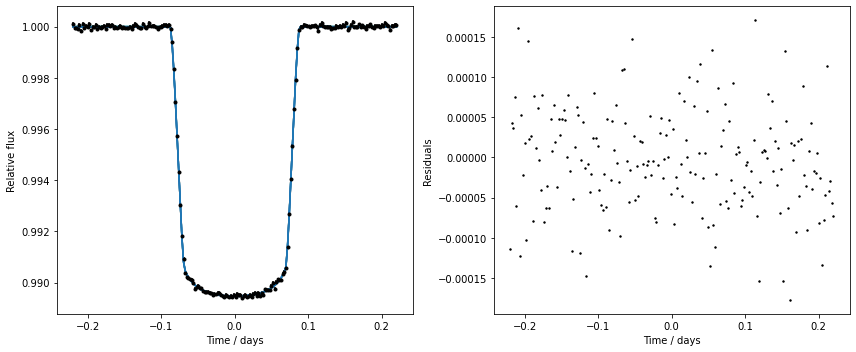

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.errorbar(times, observed_fluxes, yerr=y_sigma, fmt=".k", capsize=0)
ht.set_planet_transmission_string(np.median(chain, axis=0))
ax2.scatter(times, ht.get_transit_light_curve() - observed_fluxes, color='#000000', s=2)
for sample in chain[np.random.randint(len(chain), size=50)]:
    ht.set_planet_transmission_string(sample)
    ax1.plot(times, ht.get_transit_light_curve(),
             color='C0', alpha=0.1)
ax1.set_xlabel('Time / days')
ax1.set_ylabel('Relative flux')
ax2.set_xlabel('Time / days')
ax2.set_ylabel('Residuals')
plt.tight_layout()
plt.show()

Third, we look at the resulting transmission string and compare it to the injected model.

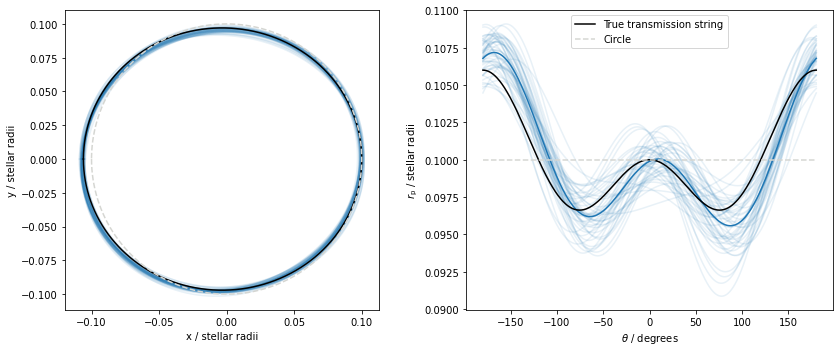

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.set_aspect('equal', 'box')
labelled = False
theta = np.linspace(-np.pi, np.pi, 1000)

for sample in chain[np.random.randint(len(chain), size=50)]:
    ht.set_planet_transmission_string(sample)
    transmission_string = ht.get_planet_transmission_string(theta)
    ax1.plot(transmission_string * np.cos(theta), transmission_string * np.sin(theta), color='C0', alpha=0.1)
    ax2.plot(theta * 180. / np.pi, transmission_string, color='C0', alpha=0.1)

ht.set_planet_transmission_string(np.median(chain, axis=0))
transmission_string = ht.get_planet_transmission_string(theta)
ax2.plot(theta * 180. / np.pi, transmission_string, color='C0', alpha=1.0)

ht.set_planet_transmission_string(rs)
transmission_string = ht.get_planet_transmission_string(theta)
ax1.plot(transmission_string * np.cos(theta), transmission_string * np.sin(theta), lw=1.5, c='#000000')
ax2.plot(theta * 180. / np.pi, transmission_string, c='#000000', lw=1.5, label='True transmission string')

ax1.plot(rs[0] * np.cos(theta), rs[0] * np.sin(theta), lw=1.5, c='#d5d6d2', ls='--')
ax2.plot(theta * 180. / np.pi, np.ones(theta.shape[0]) * rs[0], c='#d5d6d2', lw=1.5, ls='--', label='Circle')

ax2.legend(loc='upper center')
ax1.set_xlabel('x / stellar radii')
ax1.set_ylabel('y / stellar radii')
ax2.set_xlabel('$\\theta$ / degrees')
ax2.set_ylabel('$r_{\\rm{p}}$ / stellar radii')
plt.tight_layout()
plt.show()

And fourth, we look at the inferred parameter distributions.

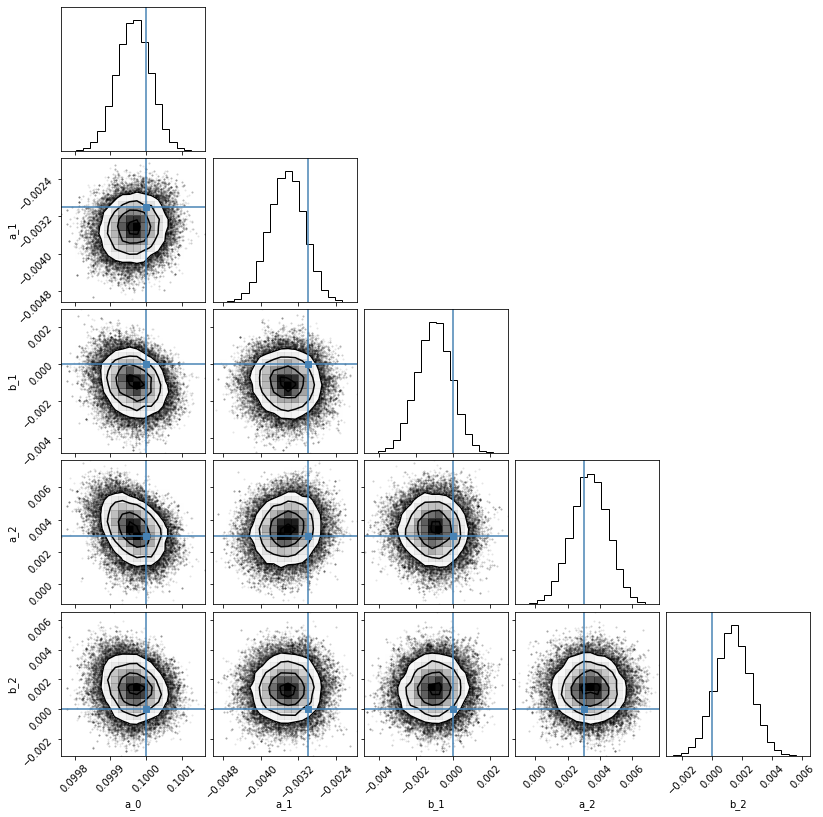

In [33]:
import corner

figure = corner.corner(chain, truths=rs, labels=var_names)
plt.show()